# Distinguishing Human and GPT-generated Text Using Only Syntax Information

## Setup

In [249]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

In [278]:
df = pd.read_csv("data/essays-with-linguistic-markers.csv")
df_pos = df[["STUD_pos", "GPT4_pos"]]
df_pos

,STUD_pos,GPT4_pos
0,PRP VBZ RB VBN IN NN MD RB VB DT NN IN NN . IN...,NN : VBG NNP CC NNP IN NNP _SP DT JJ NN NN RB ...
1,DT JJ CD NNS VBP VBN DT VBG NN IN NNS IN JJ NN...,NN : DT NNP NNP IN NN : DT NNP NNP IN NNP _SP ...
2,DT JJ NN VBZ VBN DT VBG NN IN NNS VBG TO VB JJ...,"NN : DT NNP NNP IN NNP NNP _SP IN JJ NNS , JJ ..."
3,DT JJ CD NNS VBP VBN DT JJ NN IN DT NN IN NN V...,NN : DT NNPS IN NNP NNP POS JJ NN _SP DT JJ NN...
4,PRP VBZ DT NN POS NN TO VB IN DT JJ NN CC VB D...,NN : DT NNP NNPS IN VBG CC VBG NNP _SP VBG CC ...
...,...,...
85,"RB , DT JJ NN VBG NNS VBZ VBN NNS IN NNS CC DT...",NN : DT NNP IN NNP CC NNP : DT NNP IN NNP _SP ...
86,"RB , DT NN IN NNS VBZ VBN RB VBN IN DT NN . RB...",NN : DT NNP IN NNP NNP NNS IN NNP CC NNP NNP _...
87,JJ NNS VBP IN DT NN IN DT JJ NN VBZ JJ CC JJ ....,"NN : DT NN IN NNP NNP NN _SP IN DT JJ NN , WRB..."
88,DT NNS IN NN IN NNS CC IN NN VBP VBN JJ NN . J...,"NN : DT NNP IN NNP NNP _SP IN NN , JJ NN VBZ V..."


## Wrangling/cleaning

In [284]:
def remove_title(gpt4_pos):
    return gpt4_pos.split("_SP", 1)[1].strip()

def remove_sp(pos_string):
    return pos_string.replace("_SP", "")

df_pos = df[["STUD_pos", "GPT4_pos"]]
df_pos.loc[:, "GPT4_pos"] = df_pos["GPT4_pos"].apply(remove_title)

df_pos.loc[:, "STUD_pos"] = df_pos["STUD_pos"].apply(remove_sp).apply(str.split)
df_pos.loc[:, "GPT4_pos"] = df_pos["GPT4_pos"].apply(remove_sp).apply(str.split)

df_pos

,STUD_pos,GPT4_pos
0,"[PRP, VBZ, RB, VBN, IN, NN, MD, RB, VB, DT, NN...","[DT, JJ, NN, NN, RB, VBZ, IN, DT, NN, IN, IN, ..."
1,"[DT, JJ, CD, NNS, VBP, VBN, DT, VBG, NN, IN, N...","[IN, NN, POS, JJ, NN, ,, PRP, VBP, VBG, DT, JJ..."
2,"[DT, JJ, NN, VBZ, VBN, DT, VBG, NN, IN, NNS, V...","[IN, JJ, NNS, ,, JJ, NN, VBZ, VBN, RBR, JJ, CC..."
3,"[DT, JJ, CD, NNS, VBP, VBN, DT, JJ, NN, IN, DT...","[DT, JJ, NN, IN, JJ, NN, IN, JJ, NNS, VBZ, RB,..."
4,"[PRP, VBZ, DT, NN, POS, NN, TO, VB, IN, DT, JJ...","[VBG, CC, VBG, RB, VBZ, VBN, DT, JJ, NN, IN, N..."
...,...,...
85,"[RB, ,, DT, JJ, NN, VBG, NNS, VBZ, VBN, NNS, I...","[DT, JJ, JJ, NN, VBZ, VBN, IN, DT, JJ, NN, IN,..."
86,"[RB, ,, DT, NN, IN, NNS, VBZ, VBN, RB, VBN, IN...","[DT, JJ, NN, IN, NN, NN, CC, NN, NN, IN, JJ, N..."
87,"[JJ, NNS, VBP, IN, DT, NN, IN, DT, JJ, NN, VBZ...","[IN, DT, JJ, NN, ,, WRB, NN, VBZ, VBG, RB, ,, ..."
88,"[DT, NNS, IN, NN, IN, NNS, CC, IN, NN, VBP, VB...","[IN, NN, ,, JJ, NN, VBZ, VBN, VBN, RP, IN, NNS..."


## Setting up n-gram frequency matrix

In [288]:
def get_ngram_frequencies(pos_list, n):
    ngram_list = list(zip(*[pos_list[i:] for i in range(n)]))
    total = len(ngram_list)
    counts = Counter(ngram_list)
    
    if total == 0:
        return {}
    
    freqs = {ngram: count / total for ngram, count in counts.items()}
    return freqs

def build_ngram_matrix(n):
    data = []

    for i, row in df_pos.iterrows():
        for writer in df_pos.columns:
            pos_list = row[writer]
            if isinstance(pos_list, list):
                freqs = get_ngram_frequencies(pos_list, n)
                flat_row = {"label": 0 if writer == "STUD_pos" else 1}
                flat_row.update({" ".join(k): v for k, v in freqs.items()})
                data.append(flat_row)

    return pd.DataFrame(data).fillna(0)

## Setting up logistic regression

In [271]:
def test_ngram_classifier(n):
    ngram_matrix = build_ngram_matrix(n)

    X = ngram_matrix.drop(columns="label")
    y = ngram_matrix["label"]

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.3, stratify=y, random_state=42
    )

    clf = LogisticRegression(
        max_iter=1000,
        class_weight='balanced',
        random_state=42,
        C=1.0
    )
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    print(classification_report(y_test, y_pred))

    cv_scores = cross_val_score(clf, X_scaled, y, cv=5)
    print(f"CV Mean Accuracy: {cv_scores.mean():.4f}")
    print(f"CV Std Dev: {cv_scores.std():.4f}")

    y_cv_pred = cross_val_predict(clf, X_scaled, y, cv=5)


    feature_names = X.columns
    coef_df = pd.DataFrame({
        "feature": feature_names,
        "coefficient": clf.coef_[0]
    }).sort_values(by="coefficient", ascending=False)

    return coef_df

## Testing different n-gram sizes

In [272]:
test_ngram_classifier(1)

              precision    recall  f1-score   support

           0       0.91      0.74      0.82        27
           1       0.78      0.93      0.85        27

    accuracy                           0.83        54
   macro avg       0.85      0.83      0.83        54
weighted avg       0.85      0.83      0.83        54

CV Mean Accuracy: 0.9056
CV Std Dev: 0.0283


,feature,coefficient
16,JJ,0.895292
26,VBG,0.801869
15,CC,0.738510
5,NN,0.628534
11,",",0.486906
12,NNS,0.336291
39,-LRB-,0.312859
40,-RRB-,0.312859
28,CD,0.286098
19,POS,0.218624


In [273]:
test_ngram_classifier(2)

              precision    recall  f1-score   support

           0       1.00      0.89      0.94        27
           1       0.90      1.00      0.95        27

    accuracy                           0.94        54
   macro avg       0.95      0.94      0.94        54
weighted avg       0.95      0.94      0.94        54

CV Mean Accuracy: 0.9833
CV Std Dev: 0.0222


,feature,coefficient
25,", CC",0.251585
150,", VBG",0.212700
29,JJ NN,0.191622
164,CC JJ,0.181957
151,VBG NNS,0.176874
...,...,...
53,PRP MD,-0.154707
132,NN RB,-0.157902
135,VB VBN,-0.168527
16,IN DT,-0.197930


In [275]:
test_ngram_classifier(3)

              precision    recall  f1-score   support

           0       1.00      0.93      0.96        27
           1       0.93      1.00      0.96        27

    accuracy                           0.96        54
   macro avg       0.97      0.96      0.96        54
weighted avg       0.97      0.96      0.96        54

CV Mean Accuracy: 0.9889
CV Std Dev: 0.0222


,feature,coefficient
29,"NN , CC",0.080723
724,"NNS , VBG",0.069834
315,", CC JJ",0.067341
330,. IN VBG,0.056301
316,CC JJ NN,0.056096
...,...,...
469,"RB , PRP",-0.047717
677,"RB , IN",-0.047978
71,PRP MD VB,-0.050214
251,MD VB VBN,-0.053331


In [276]:
test_ngram_classifier(4)

              precision    recall  f1-score   support

           0       1.00      0.63      0.77        27
           1       0.73      1.00      0.84        27

    accuracy                           0.81        54
   macro avg       0.86      0.81      0.81        54
weighted avg       0.86      0.81      0.81        54

CV Mean Accuracy: 0.8833
CV Std Dev: 0.0509


,feature,coefficient
385,", NN , CC",0.031500
436,CC JJ NN .,0.030904
424,"NN , CC JJ",0.029576
384,"NN , NN ,",0.029212
59,"JJ NN , CC",0.028676
...,...,...
2592,"RB , PRP VBP",-0.020680
76,", PRP RB VBP",-0.020829
676,". RB , PRP",-0.021723
980,IN DT NN .,-0.022191


In [291]:
test_ngram_classifier(5)

              precision    recall  f1-score   support

           0       1.00      0.22      0.36        27
           1       0.56      1.00      0.72        27

    accuracy                           0.61        54
   macro avg       0.78      0.61      0.54        54
weighted avg       0.78      0.61      0.54        54

CV Mean Accuracy: 0.5944
CV Std Dev: 0.0624


,feature,coefficient
433,"NN , NN , CC",0.017545
482,"NN , CC JJ NN",0.013346
568,JJ NN . IN VBG,0.012253
1978,"IN JJ NNS , VBG",0.011933
1099,", JJ NN , CC",0.011885
...,...,...
3395,". RB , PRP VBP",-0.010771
4119,"DT NN . RB ,",-0.011501
2035,IN DT JJ NN CC,-0.011576
2067,". IN PRP$ NN ,",-0.011858


In [292]:
test_ngram_classifier(6)

              precision    recall  f1-score   support

           0       1.00      0.04      0.07        27
           1       0.51      1.00      0.68        27

    accuracy                           0.52        54
   macro avg       0.75      0.52      0.37        54
weighted avg       0.75      0.52      0.37        54

CV Mean Accuracy: 0.5222
CV Std Dev: 0.0208


,feature,coefficient
505,"NN , NN , CC JJ",0.009794
1540,DT NN IN JJ NN .,0.009695
3598,"CC JJ NN . RB ,",0.009565
455,"IN NN , NN , CC",0.009260
6636,NN IN JJ NN NNS .,0.008873
...,...,...
1974,"JJ NNS . RB , PRP",-0.007653
4165,JJ NN IN DT NN .,-0.007677
15616,JJ NN IN DT JJ NNS,-0.007969
4711,NN IN DT NN . RB,-0.008013


## Plotting results

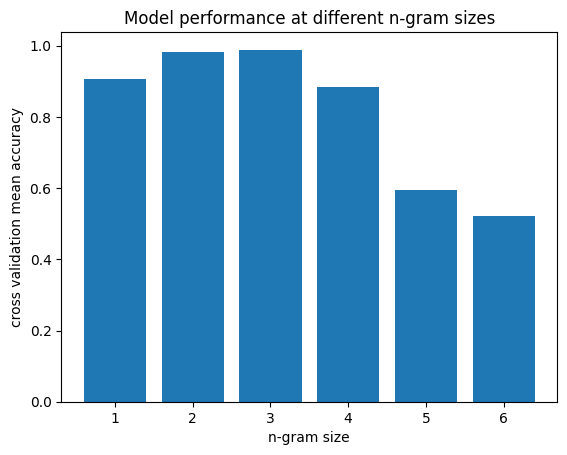

In [293]:
cv_scores = [0.9056, 0.9833, 0.9889, 0.8833, 0.5944, 0.5222]
plt.bar(x=range(1, 7), height=cv_scores)
plt.title("Model performance at different n-gram sizes")
plt.xlabel("n-gram size")
plt.ylabel("cross validation mean accuracy")
plt.show()